# TICA: Time-lagged independent component analysis

### Import

In [1]:
# IMPORT PACKAGES
import torch
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Unbiased data (high temperature MD)

### Load MD data

In [2]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,lag_time=1)

/home/lbonati@iit.local/work/code/mlcolvar/mlcolvar/utils/timelagged.py:139: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_new.cpp:230.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)


### Prepare dataset

In [3]:
from mlcolvar.utils.timelagged import find_timelagged_configurations

X = df.filter(regex='p.x|p.y').values
t = df['time'].values

# find time-lagged configurations
x_t,x_lag,w_t,w_lag = find_timelagged_configurations(X,t,lag_time=10)

print('len(x(t)):',X.shape)

100%|██████████| 4989/4989 [00:00<00:00, 195560.67it/s]

len(x(t)): (5001, 2)


### Compute TICA

In [4]:
from mlcolvar.core.stats import TICA

n_components = 2 
tica = TICA (in_features=2, out_features=n_components)

eigvals, eigvecs = tica.compute(data=[x_t,x_lag], weights=[w_t,w_lag], save_params=True)
s = tica(torch.Tensor(X))

print(X.shape, '-->', s.shape)

(5001, 2) --> torch.Size([5001, 2])


### Get eigenvector coefficients

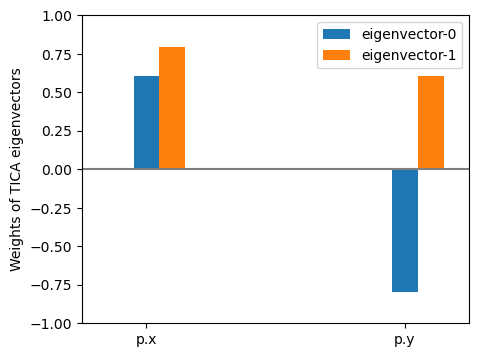

In [5]:
# inspect eigenvector(s)
fig,ax = plt.subplots(figsize=(5,4),dpi=100)

for i in range(n_components):
    eigvec = eigvecs[:,i]
    ax.bar(np.arange(len(eigvec))+0.1*i,eigvec,width=0.1, label=f'eigenvector-{i}')

ax.set_ylabel('Weights of TICA eigenvectors')
ax.axhline(0,c='grey')
ax.set_xticks([0,1])
ax.set_xticklabels(['p.x','p.y'])
ax.set_xlim(-0.25,1.25)
ax.set_ylim(-1,1)
ax.legend()
plt.show()


### Visualize CV isolines

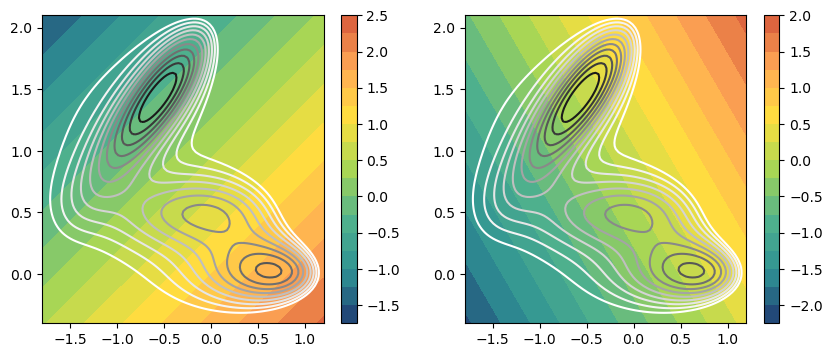

In [6]:
# Inspect linear combination vs potential
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(tica, component=i, levels=15, ax=ax)